# <font > clustering algorithm to group similar actors in graph data</font>

 we have get maximum score of <b>$Cost1*Cost2$</b><br>
 Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 

 Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

  and Fitting the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
  and Converting the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 and Plotting the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font >  clustering algorithm to group similar movies in graph data</font>

we have to get maximum score of $Cost1*Cost2$ 

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>

	
Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 



**Algorithm for actor nodes**

<br>

In [1]:
#installing networkx to retriew data form graph.
!pip install networkx==2.3

     |████████████████████████████████| 1.8MB 2.3MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=d9d09c496ca8541d25c65e90f9444bf3332439b2c5f1ce974eb549af0ea01efe
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5.1
    Uninstalling networkx-2.5.1:
      Successfully uninstalled networkx-2.5.1


In [2]:
pip install stellargraph

     |████████████████████████████████| 440kB 3.2MB/s 


In [3]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import tensorflow as tf
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [4]:
#reading the data.
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [5]:
edges = [tuple(x) for x in data.values.tolist()]

In [6]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [7]:
A = list(nx.connected_component_subgraphs(B))[0]

In [8]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


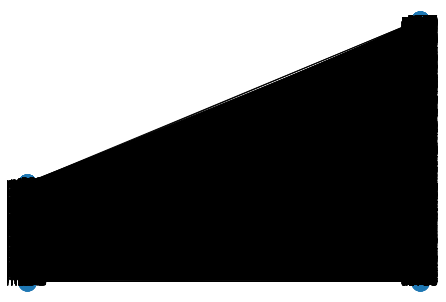

In [9]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [10]:
#spilitting the data into movies and actors.
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [11]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [12]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [13]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [14]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [15]:
X=node_embeddings.reshape(-1,1)

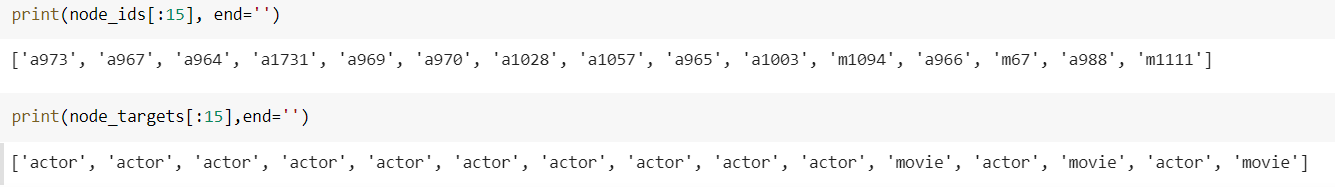

In [16]:
from operator import itemgetter 
import numpy as np
#The function data_split split the data into actor,movie nodes and embeddings.
def data_split(node_ids,node_targets,node_embeddings):
  actor_nodes,movie_nodes=[],[]
  actor_embeddings,movie_embeddings=[],[]
  idx1=[]
  idx2=[]
  for i in node_ids:
    if 'm' in i:
      idx1.append(node_ids.index(i))
    if 'a' in i:
      idx2.append(node_ids.index(i))
  actor_embeddings=np.array([node_embeddings[i] for i in idx2])
  movie_embeddings=np.array([node_embeddings[i] for i in idx1])
  actor_nodes=np.array([node_ids[i] for i in idx2])
  movie_nodes=np.array([node_ids[i] for i in idx1])
  return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [17]:
#splitting the data into movie,actor nodes and embeddings.
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [33]:
#this function cost1 compute cost1 for the graph.
def cost1(graph,number_of_clusters):
    no_of_nodes=0
    cost=0
    for i in range(1,number_of_clusters):
      largest_cc = max(nx.connected_components(graph), key=len)
      c=len(largest_cc)/graph.number_of_nodes()
    cost=(c+cost)/number_of_clusters
    return cost

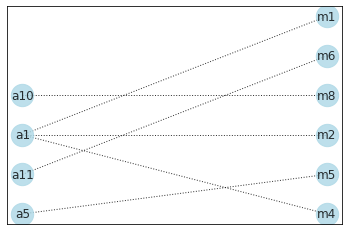

In [34]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

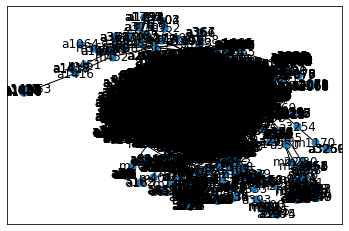

In [36]:
#displaying the fully biparted graph.
nx.draw_networkx(B,node_size=50)

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [37]:
#this function cost2 computes cost2 for  graph.
def cost2(graph,number_of_clusters):
    c2=0
    for i in range(1,number_of_clusters):
      nume=sum([v for (n,v) in graph.degree() if 'a' in n])
      denom=len([node for node in graph.nodes() if 'm' in node])
      f=nume/denom
    cost2=(c2+f)
    return cost2/number_of_clusters

In [56]:
import networkx as nx
from collections import defaultdict
import networkx as nx 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from collections import Counter



def ggf():
  cl=[3,5,10,30,50,100,200,500]
  #Iterating through each cluster value.
  for i in range(len(cl)):
    #intializing the kmeans algorithm
    clf=KMeans(n_clusters=cl[i])
    clf.fit(actor_embeddings)
    #getttig the labels
    labels=clf.labels_
    #print(len(labels))
    new_dict = {actor_nodes[i]: labels[i] for i in range(len(actor_nodes))}
    res = defaultdict(list)
    #print(len(new_dict))
    list_of_clusters=[]
    for key, val in sorted(new_dict.items()):
      res[val].append(key)
    for v1 in dict(res).values():
      list_of_clusters.append(v1)
    cost_list=[]
    #computing cost for given list of cluster sizes.
    for cluster in list_of_clusters:
      G=nx.Graph()
      for actor in cluster:
        ego_graph=nx.ego_graph(B,actor)
        G.add_nodes_from(ego_graph.nodes())
        G.add_edges_from(ego_graph.edges())
      cost=cost1(G,len(cl))+cost2(G,len(cl))
      cost_list.append(cost)
    print("number of clusters {}-------cost {}".format(cl[i],sum(cost_list)))

In [57]:
ggf()

number of clusters 3-------cost 1.8778578003714346
number of clusters 5-------cost 2.61399606794816
number of clusters 10-------cost 4.260581228383976
number of clusters 30-------cost 10.94220000854043
number of clusters 50-------cost 17.030729862812702
number of clusters 100-------cost 35.76198583999084
number of clusters 200-------cost 71.35556411134121
number of clusters 500-------cost 186.59536572380867


<font color='blue'>Grouping similar actors</font>

In [41]:
#fitting 'kmeans' alogoritmm for the actor embedding with optimal 'n_clusters'.
clf_ACTOR=KMeans(n_clusters=500)
clf_ACTOR.fit(actor_embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=500, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [58]:
#assigning label numbers for each actor node.
labels1=clf_ACTOR.labels_
new_dict1 = {actor_nodes[i]: labels1[i] for i in range(len(actor_nodes))}
res1 = defaultdict(list)
node_c=[]
for i,j in new_dict1.items():
  node_c.append(j)


<font color='blue'>Displaying similar actor clusters</font>

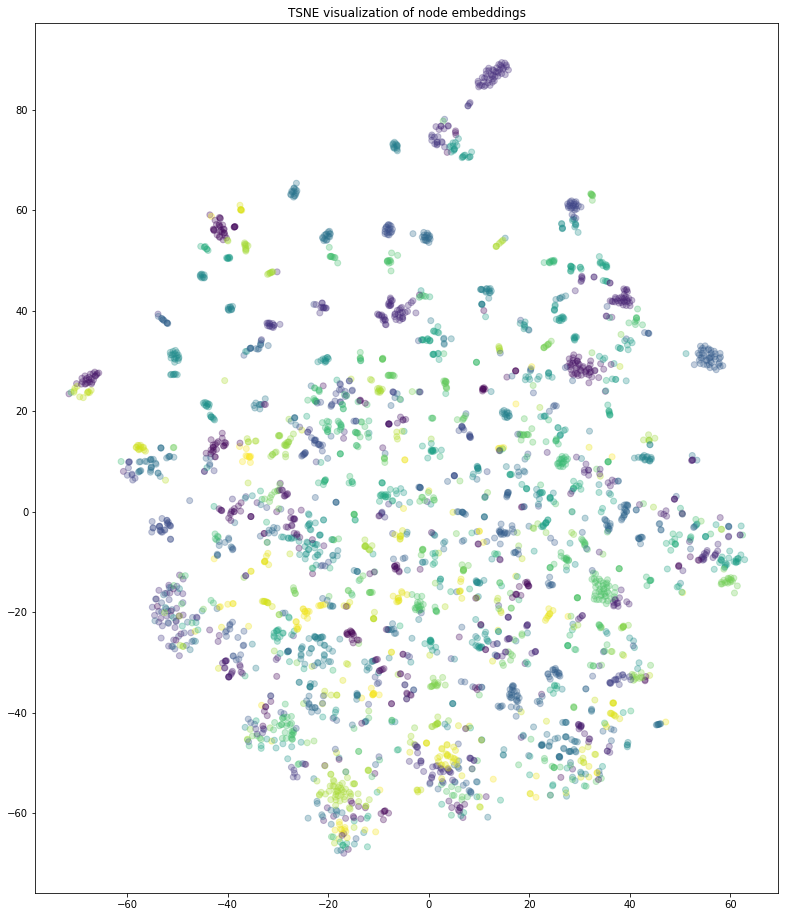

In [45]:
#displaying the actor nodes with same colour having same cluster.
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)
import numpy as np

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_c, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

<font color='blue'>Grouping similar movies</font>

In [46]:
#fitting 'kmeans' alogoritmm for the movie embedding with optimal 'n_clusters'.
clf_MOVIE=KMeans(n_clusters=500)
clf_MOVIE.fit(movie_embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=500, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
#assigning label numbers for each movie node.
labels2=clf_MOVIE.labels_
new_dict2 = {movie_nodes[i]: labels2[i] for i in range(len(movie_nodes))}
res2 = defaultdict(list)
node_a=[]
for i,j in new_dict2.items():
  node_a.append(j)

<font color='blue'>Displaying similar movie clusters</font>

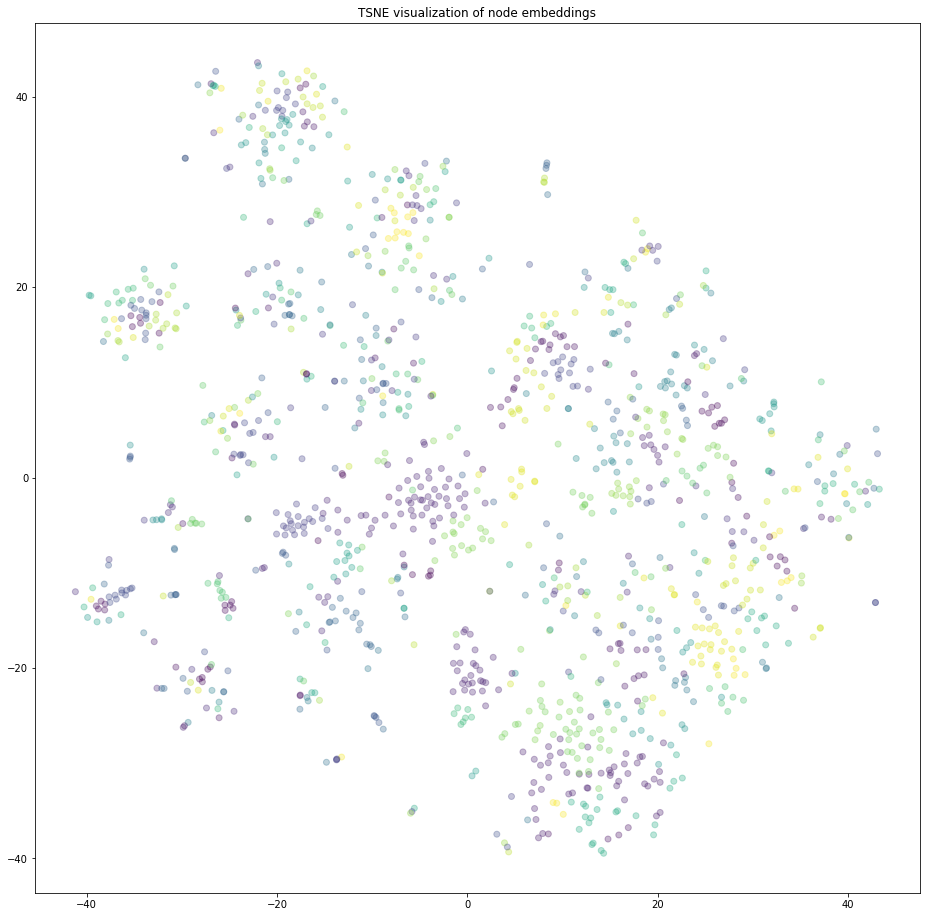

In [50]:
#displaying the movie nodes with same colour having same cluster.
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]
#node_targets = labels1
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_a, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()